In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

plt.style.use("papers")
pw.overwrite_axisgrid()

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

FOLDER = "../../results/aggregated/"

<Figure size 72x72 with 0 Axes>

In [2]:
segmentations = (
    xr.open_dataarray(os.path.join(FOLDER, "segmentations.nc"))
    .squeeze()
    .sel({"data_type": "EC", "surrogate_type": "real_data"})
    .rename({"decomposition_type": "algorithm"})
)
segm_df = (
    segmentations.to_series()
    .reset_index()
    .replace({"hmm": "HMM", "kmeans": "mod. K-Means"})
    .rename(columns={0: "segmentation"})
)

In [3]:
segm_corrs = (
    segm_df.pivot(
        index=["subject_id", "time"], columns="algorithm", values="segmentation"
    )
    .groupby("subject_id")
    .corr("spearman")
    .unstack()
)

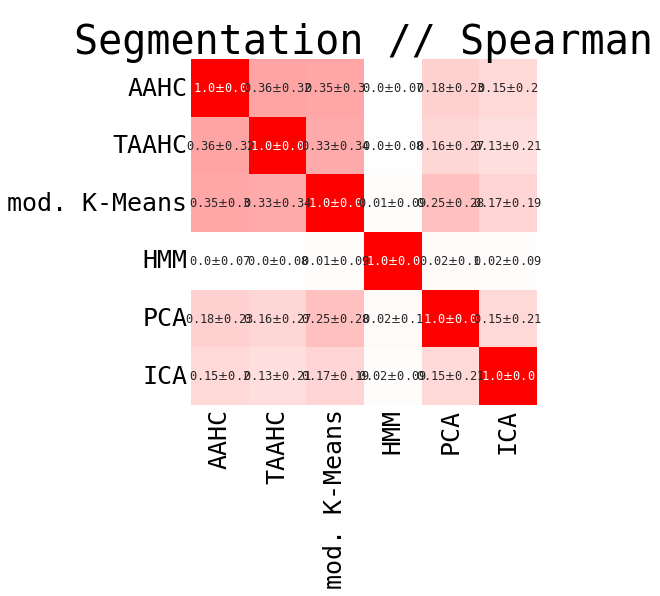

In [4]:
segm_mean = segm_corrs.mean().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_mean.index.name = ""
segm_mean.columns.name = ""

segm_std = segm_corrs.std().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_std.index.name = ""
segm_std.columns.name = ""

g1 = pw.Brick("ax0", figsize=(6, 6))
sns.heatmap(
    segm_mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
    ax=g1,
)
g1.set_title("Segmentation // Spearman")
g1.savefig(quick=True)

In [5]:
stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats = stats[(stats["surrogate_type"] == "real_data") & (stats["data_type"] == "EC")]
stats = stats.rename(columns={"decomposition_type": "algorithm"}).replace(
    {"hmm": "HMM", "kmeans": "mod. K-Means"}
)
stats = stats.sort_values(by="algorithm")

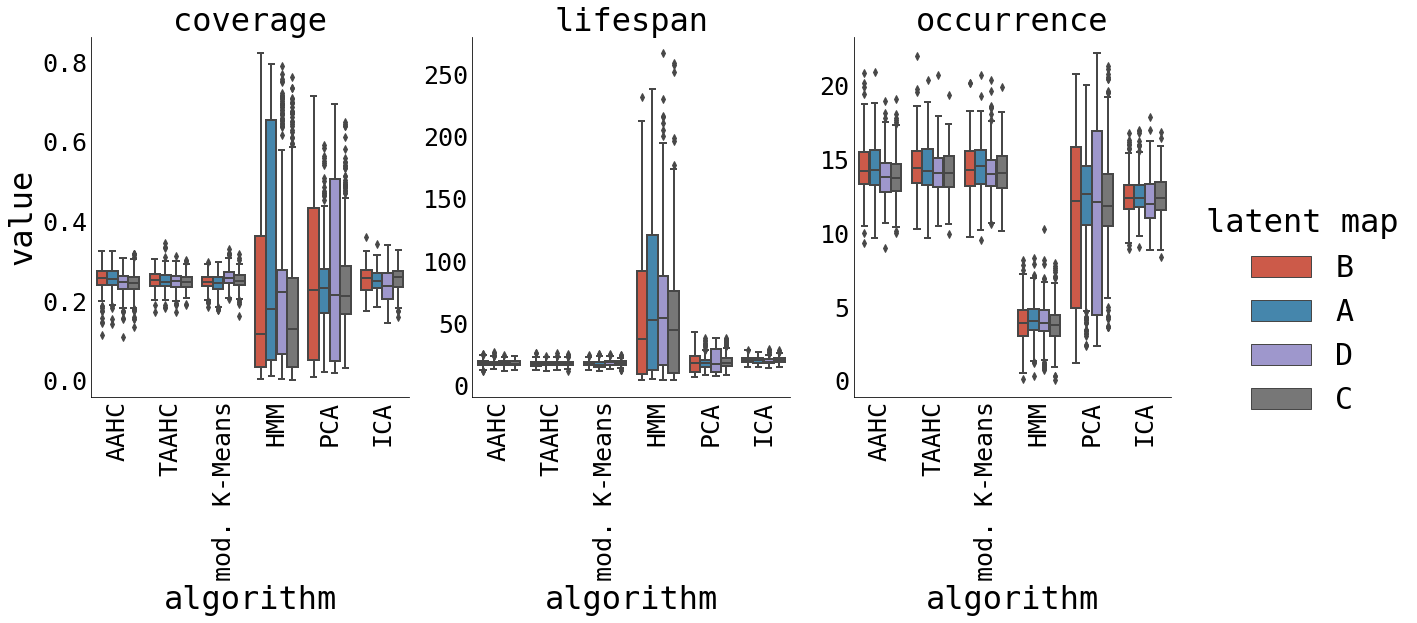

In [6]:
stats = (
    stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")

g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

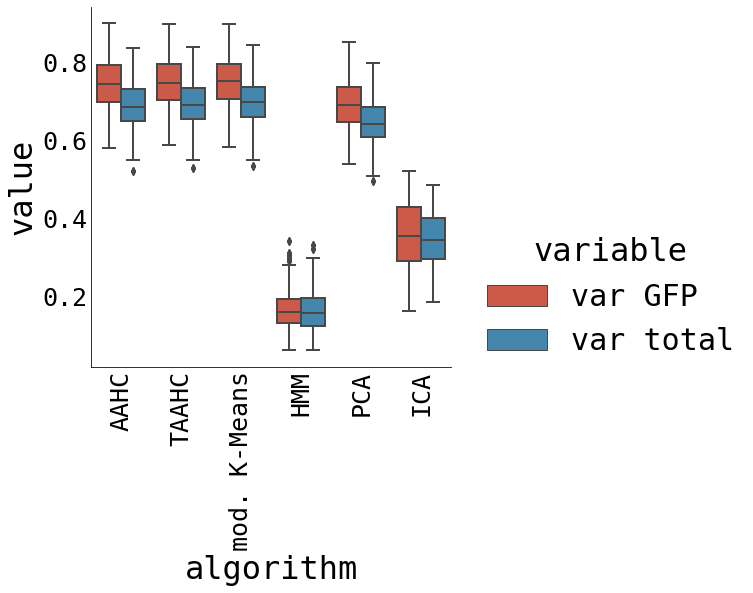

In [7]:
g = sns.catplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

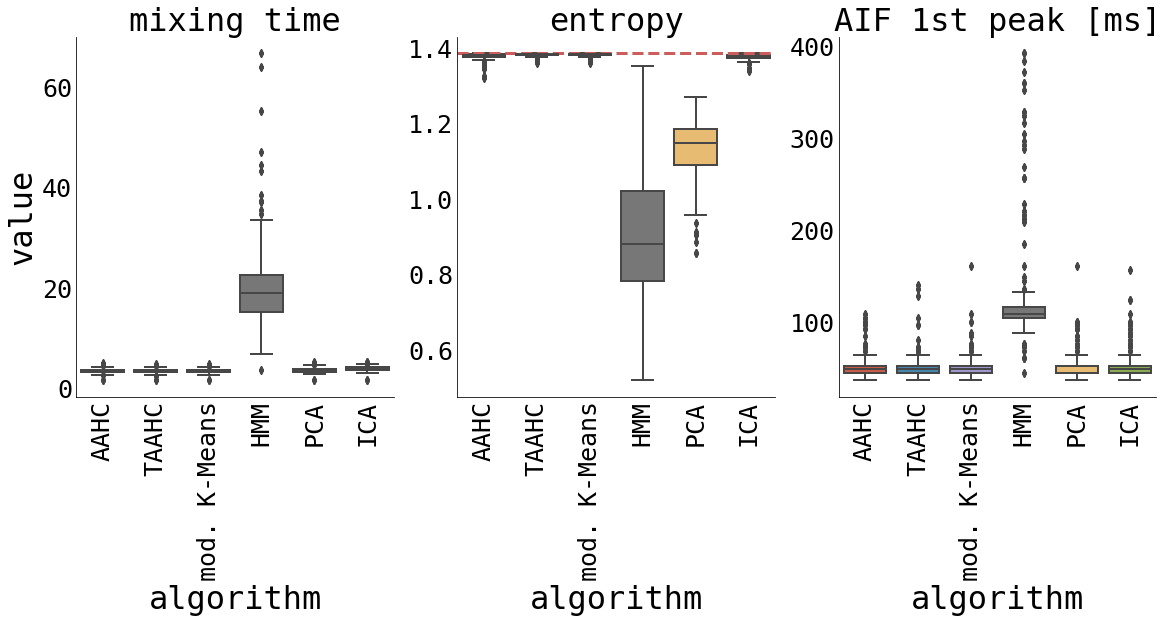

In [8]:
dynstats_melt = (
    stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak [ms]"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

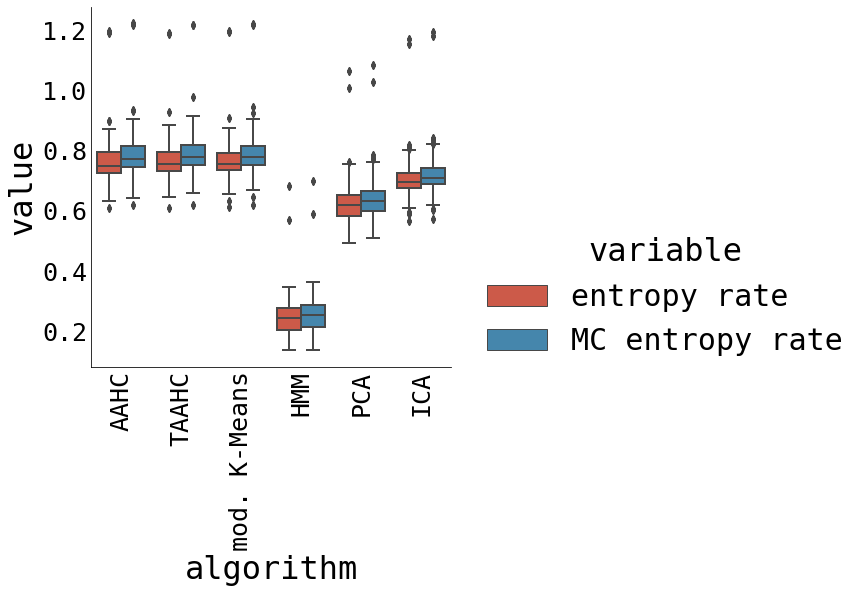

In [9]:
g = sns.catplot(
    data=stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [10]:
subj_topo = (
    xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))
    .squeeze()
    .sel({"data_type": "EC", "surrogate_type": "real_data"})
    .rename({"decomposition_type": "algorithm"})
)
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
subj_topo["algorithm"] = [
    rename_algs[str(alg.values)] for alg in subj_topo["algorithm"]
]
# subj_topo = subj_topo.stack(all=("data_type", "surrogate_type", "subject_id"))

In [11]:
subj_topo

<xarray.DataArray (algorithm: 6, subject_id: 203, latent map: 4, channels: 61)>
[297192 values with dtype=float64]
Coordinates:
  * subject_id      (subject_id) object 'sub-010002' ... 'sub-010321'
  * latent map      (latent map) object 'A' 'B' 'C' 'D'
  * channels        (channels) int64 0 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59 60
    no_states       int64 ...
  * algorithm       (algorithm) <U12 'AAHC' 'ICA' 'PCA' ... 'HMM' 'mod. K-Means'
    surrogate_type  <U9 'real_data'
    data_type       <U2 'EC'

In [12]:
all_corrs = []
for alg1 in subj_topo["algorithm"]:
    for alg2 in subj_topo["algorithm"]:
        for map1 in subj_topo["latent map"]:
            for map2 in subj_topo["latent map"]:
                corrs = (
                    xr.corr(
                        subj_topo.sel({"algorithm": alg1, "latent map": map1}),
                        subj_topo.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

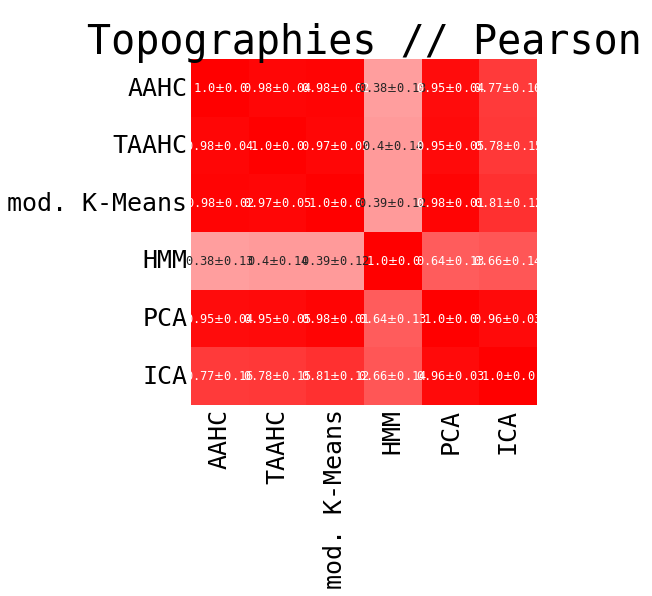

In [13]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject_id")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index.name = ""
mean.columns = mean.columns.get_level_values(1)
mean.columns.name = ""
mean = mean.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject_id", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std.index.name = ""
std.columns = std.columns.get_level_values(1)
std.columns.name = ""
std = std.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

g6 = pw.Brick("ax2", figsize=(6, 6))
sns.heatmap(
    mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=mean.round(2).astype(str) + "$\pm$" + std.round(2).astype(str),
    fmt="",
    ax=g6,
)
g6.set_title("Topographies // Pearson")
g6.savefig(quick=True)

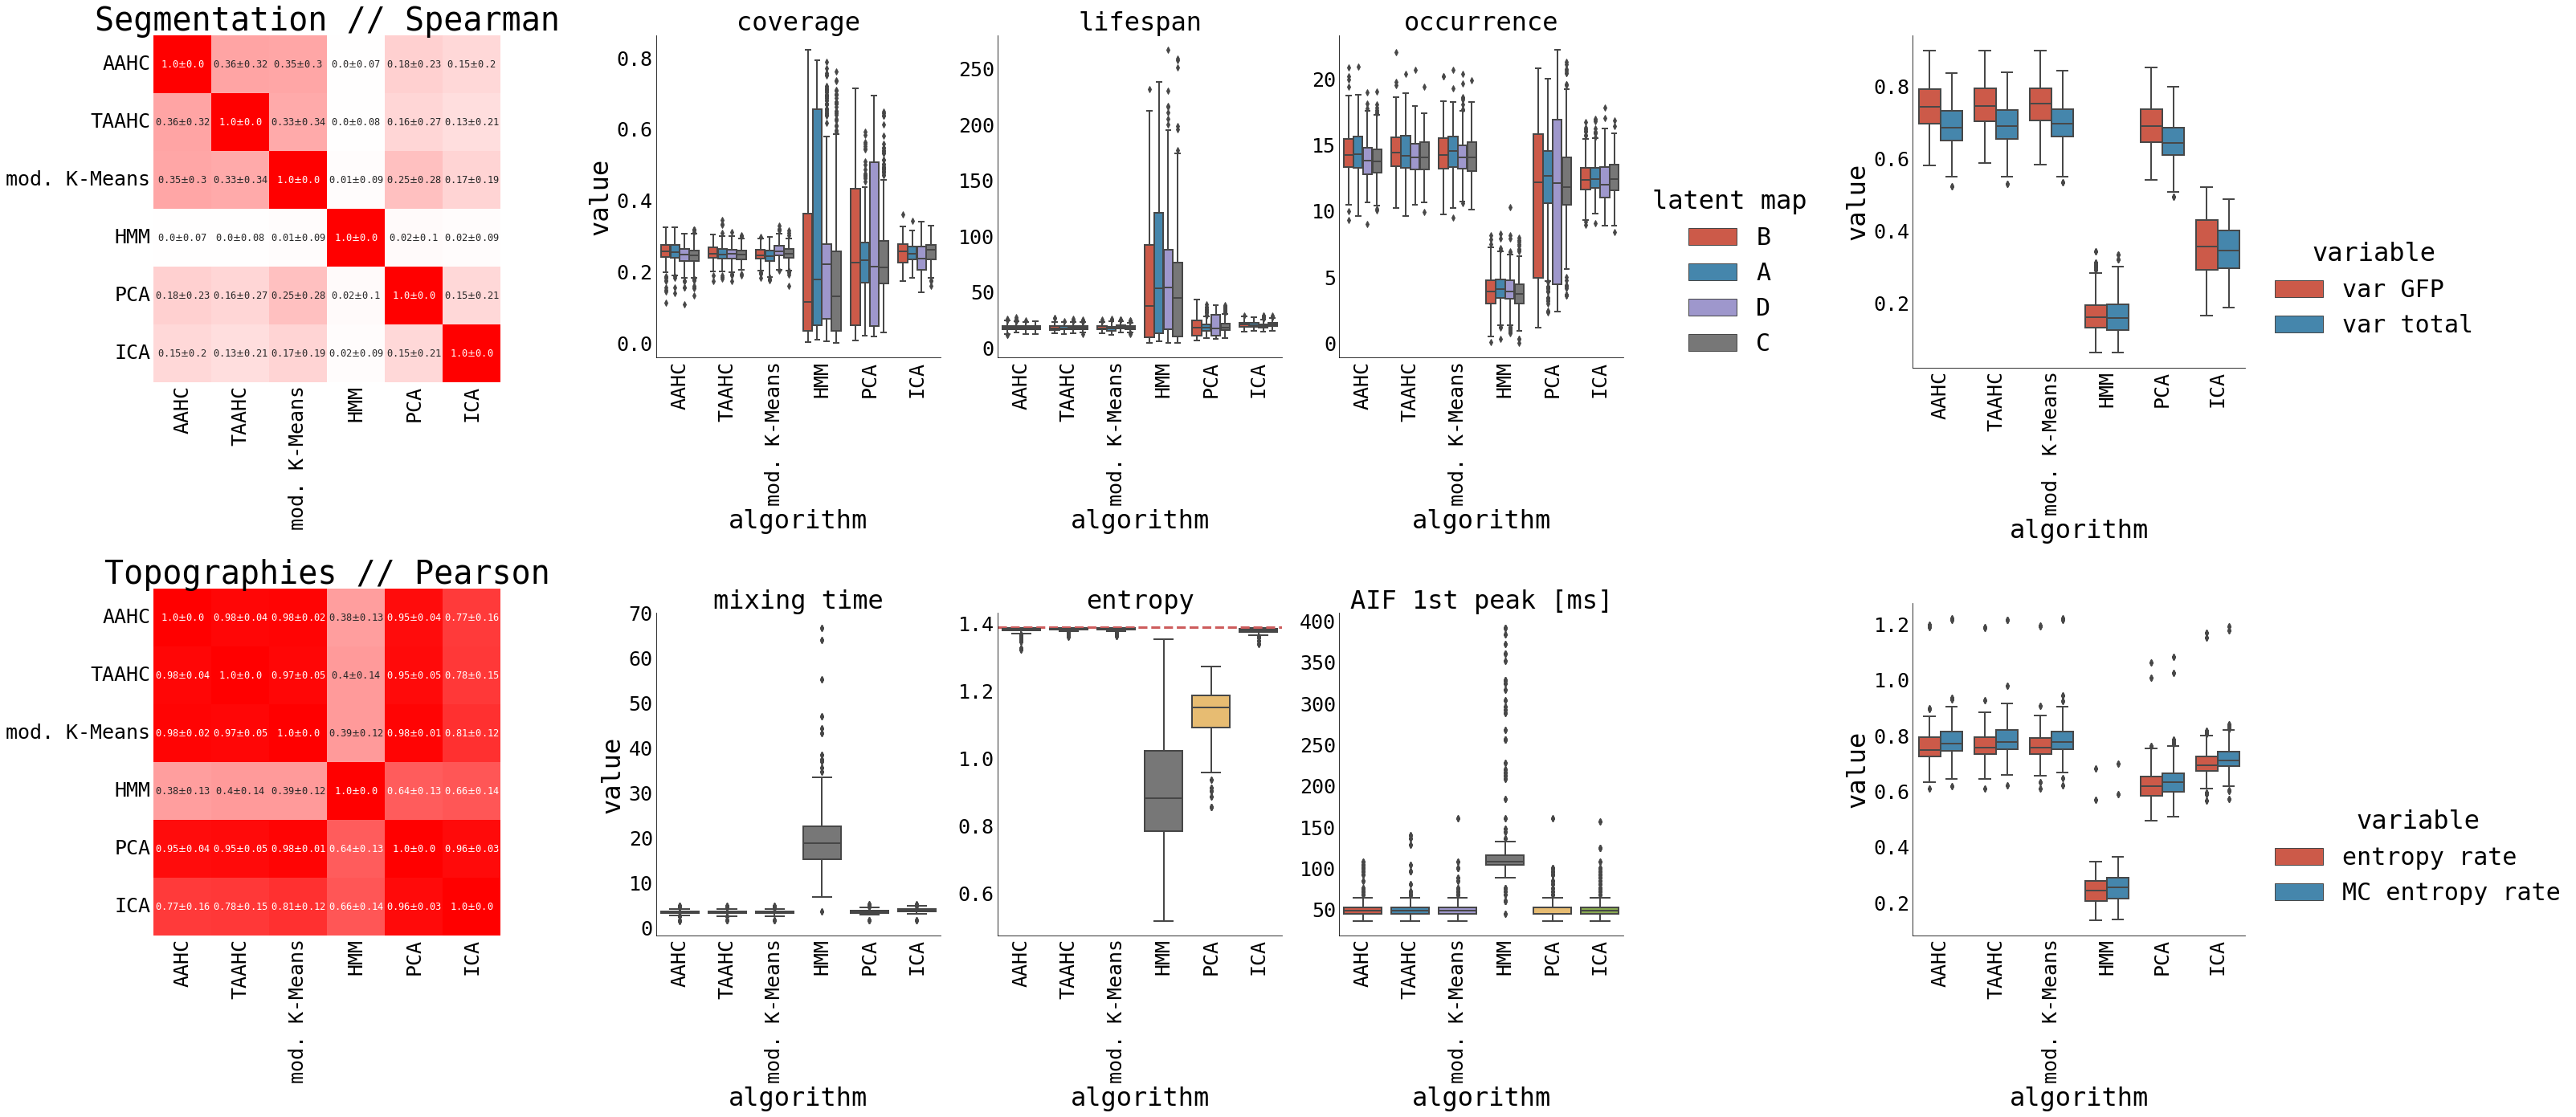

In [14]:
((g1 / g6) | (g2 / g4) | (g3 / g5)).savefig(
    fname="LEMON_data_EC_stats.pdf", transparent=True
)

In [15]:
def get_pca(decomp):
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["PC 0", "PC 1"])
    low_dim["map"] = subj_topo.stack(samples=("subject_id", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="PC 0", y="PC 1", hue="map")
    g.ax_joint.legend_._visible = False
    g.ax_marg_x.set_title(decomp)
    return g


def get_tsne(decomp):
    tsne = TSNE(n_components=2, init="pca", n_jobs=6)
    pcs = tsne.fit_transform(
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["t-SNE 0", "t-SNE 1"])
    low_dim["map"] = subj_topo.stack(samples=("subject_id", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="t-SNE 0", y="t-SNE 1", hue="map")
    g.ax_joint.legend_._visible = False
    return g


def get_mds(decomp):
    mds = MDS(n_components=2, n_jobs=6)
    pcs = mds.fit_transform(
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["MDS 0", "MDS 1"])
    low_dim["map"] = subj_topo.stack(samples=("subject_id", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="MDS 0", y="MDS 1", hue="map")
    g.ax_joint.legend_._visible = False
    return g


def get_lle(decomp):
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, n_jobs=6)
    pcs = lle.fit_transform(
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["LLE 0", "LLE 1"])
    low_dim["map"] = subj_topo.stack(samples=("subject_id", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="LLE 0", y="LLE 1", hue="map")
    g.ax_joint.legend_._visible = False
    return g


# maps["algorithm"] = ["AAHC", "HMM", "ICA", "PCA", "TAAHC", "mod. K-Means"]

g10 = pw.load_seaborngrid(get_pca("AAHC"))
g11 = pw.load_seaborngrid(get_pca("TAAHC"))
g12 = pw.load_seaborngrid(get_pca("mod. K-Means"))
g13 = pw.load_seaborngrid(get_pca("HMM"))
g14 = pw.load_seaborngrid(get_pca("PCA"))
g15 = pw.load_seaborngrid(get_pca("ICA"))

g20 = pw.load_seaborngrid(get_tsne("AAHC"))
g21 = pw.load_seaborngrid(get_tsne("TAAHC"))
g22 = pw.load_seaborngrid(get_tsne("mod. K-Means"))
g23 = pw.load_seaborngrid(get_tsne("HMM"))
g24 = pw.load_seaborngrid(get_tsne("PCA"))
g25 = pw.load_seaborngrid(get_tsne("ICA"))

g30 = pw.load_seaborngrid(get_mds("AAHC"))
g31 = pw.load_seaborngrid(get_mds("TAAHC"))
g32 = pw.load_seaborngrid(get_mds("mod. K-Means"))
g33 = pw.load_seaborngrid(get_mds("HMM"))
g34 = pw.load_seaborngrid(get_mds("PCA"))
g35 = pw.load_seaborngrid(get_mds("ICA"))

g40 = pw.load_seaborngrid(get_lle("AAHC"))
g41 = pw.load_seaborngrid(get_lle("TAAHC"))
g42 = pw.load_seaborngrid(get_lle("mod. K-Means"))
g43 = pw.load_seaborngrid(get_lle("HMM"))
g44 = pw.load_seaborngrid(get_lle("PCA"))
g45 = pw.load_seaborngrid(get_lle("ICA"))

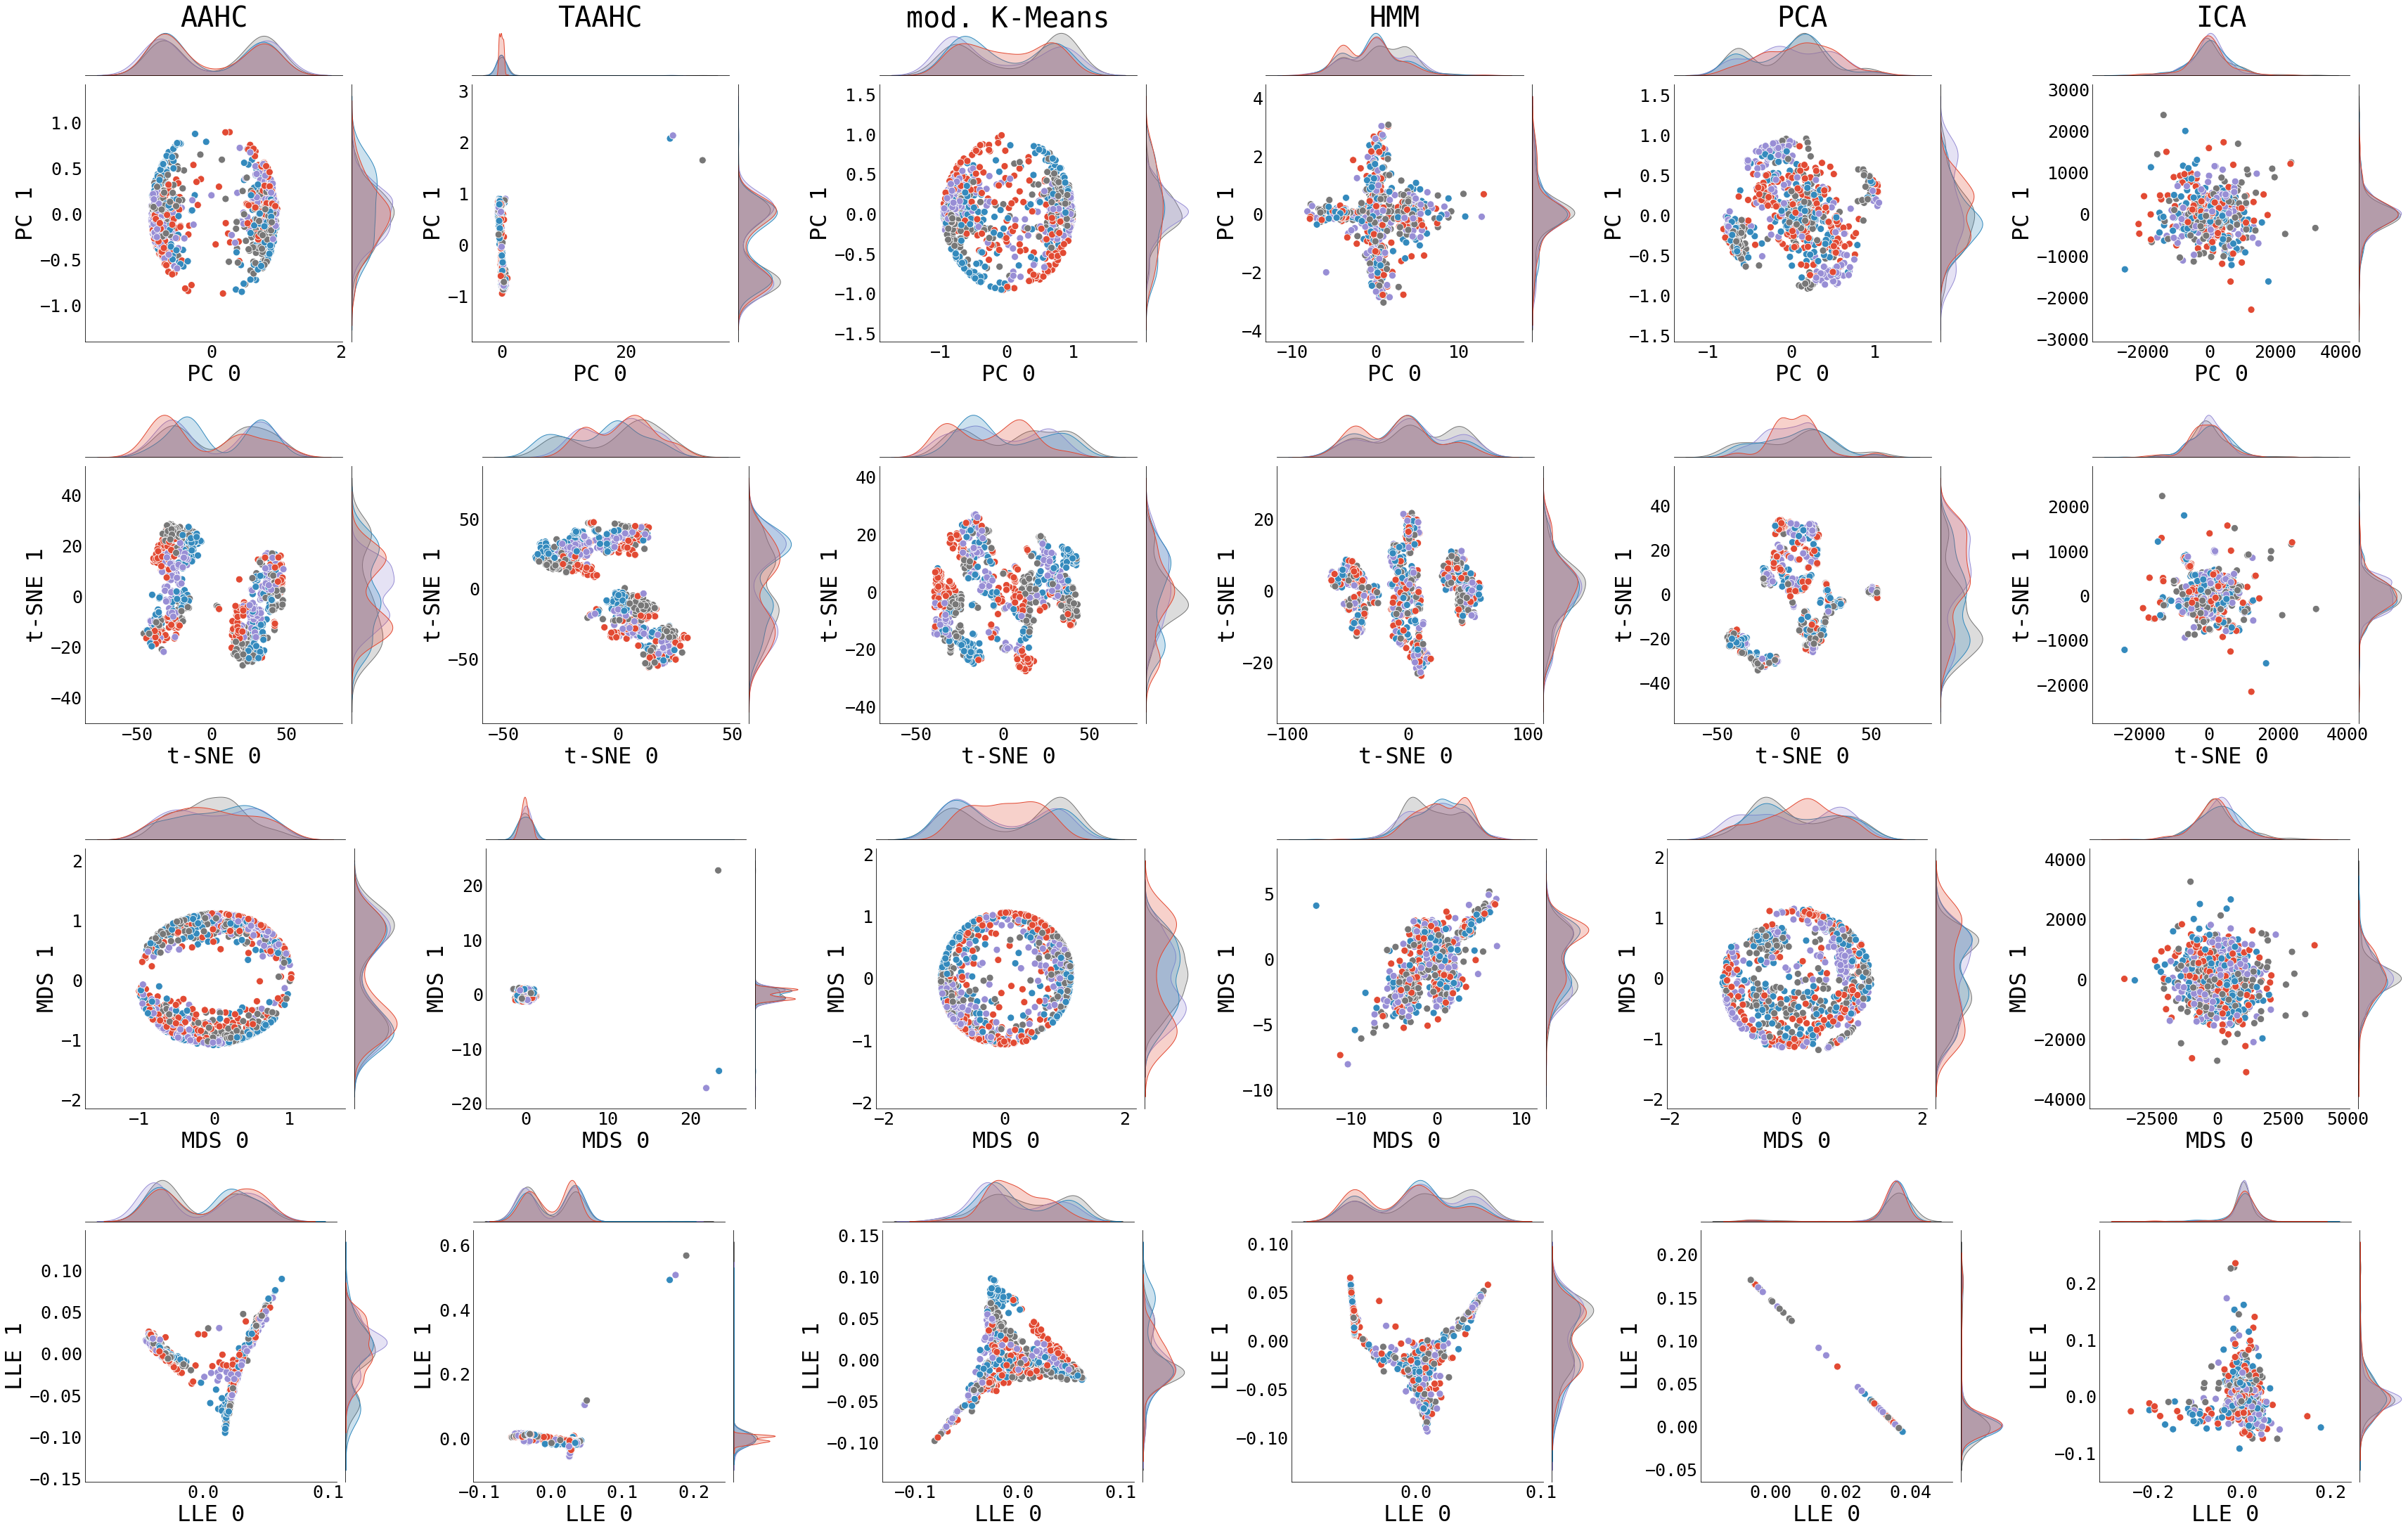

In [16]:
(
    (g10 | g11 | g12 | g13 | g14 | g15)
    / (g20 | g21 | g22 | g23 | g24 | g25)
    / (g30 | g31 | g32 | g33 | g34 | g35)
    / (g40 | g41 | g42 | g43 | g44 | g45)
).savefig(fname="LEMON_data_EC_lowdim_repr.pdf", transparent=True)